In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [2]:
df = (
    pd.read_csv('data.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [3]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

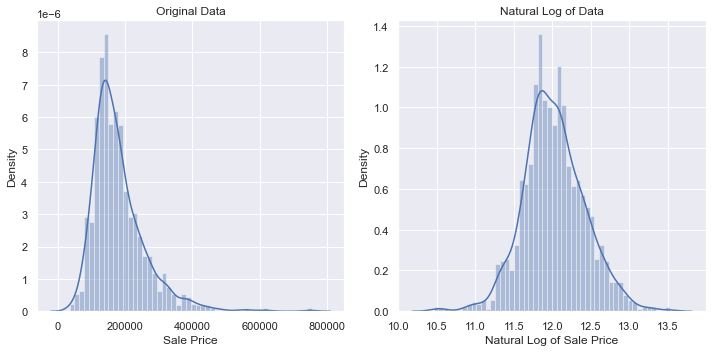

In [4]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [5]:
### Your code is here
col_drop = X.columns[X.isna().sum()/( X.isna().sum()+ X.count()) > 0.15].to_list()
col_drop

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [6]:
# X = X.dropna(axis=1, thresh=0.15*df.shape[0])

In [7]:
X.drop(col_drop,axis=1, inplace=True)
X.shape

(1460, 73)

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные, а затем переведите в строки.

In [8]:
col_obj = ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']

In [9]:
### Your code is here
categorical_columns = X.loc[:,X.dtypes==object].columns.to_list() + col_obj
for col in categorical_columns:
    popular_category = X[col].value_counts().index[0]
    X[col].fillna(popular_category, inplace=True)
X[col_obj] = X[col_obj].astype(str)
# X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

In [10]:
numeric_columns = list(set(X.loc[:,X.dtypes!=object].columns.to_list()) - set(col_obj))
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median()) 

In [11]:
X.to_csv('hw19_5.csv', index=False, sep=',')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [13]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cols_for_ohe = [x for x in categorical_columns if X_train[x].nunique() < 5]
cols_for_mte = [x for x in categorical_columns if X_train[x].nunique() >= 5]
cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_columns]

### Your code is here
t = [('StandardScaler', StandardScaler(), numeric_cols_idx),
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
     ]

col_transform = ColumnTransformer(transformers=t)

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here
pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeRegressor(random_state = 1))])

pipe_dt.fit(X_train, y_train)
train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {round(train_error,3)}")
print(f"Качество на тесте: {round(test_error,3)}")
##0.038, а приняло 0.039

Качество на трейне: 0.0
Качество на тесте: 0.033


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [16]:
np.random.seed = 1

param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}
from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("random_forest", 
                               RandomForestRegressor(max_depth=10,
                                                     verbose=1))])
### Your code is here
custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]

from sklearn.model_selection import GridSearchCV
search = GridSearchCV(RandomForest_pipe, 
                      param_grid, 
                      cv=custom_cv,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X, log_target)


Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.019 total time=   5.0s
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.019 total time=   4.5s
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=   4.2s
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 4/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2;, score=-0.019 total time=   4.8s
[CV 1/1; 5/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 5/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5;, score=-0.019 total time=   6.2s
[CV 1/1; 6/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 6/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10;, score=-0.019 total time=   2.9s
[CV 1/1; 7/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 7/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2;, score=-0.019 total time=   2.5s
[CV 1/1; 8/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 8/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5;, score=-0.020 total time=   3.7s
[CV 1/1; 9/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 1/1; 9/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10;, score=-0.020 total time=   5.6s
[CV 1/1; 10/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 1/1; 10/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.018 total time=   7.9s
[CV 1/1; 11/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV 1/1; 11/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.018 total time=  14.0s
[CV 1/1; 12/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 1/1; 12/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=  16.2s
[CV 1/1; 13/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 13/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2;, score=-0.019 total time=   5.9s
[CV 1/1; 14/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 14/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5;, score=-0.019 total time=   6.1s
[CV 1/1; 15/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 1/1; 15/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10;, score=-0.019 total time=   4.2s
[CV 1/1; 16/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 16/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2;, score=-0.019 total time=   4.1s
[CV 1/1; 17/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 17/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5;, score=-0.019 total time=   3.3s
[CV 1/1; 18/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 18/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10;, score=-0.019 total time=   4.3s
[CV 1/1; 19/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 19/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.018 total time=   2.8s
[CV 1/1; 20/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 20/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.018 total time=   2.7s
[CV 1/1; 21/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 21/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.018 total time=   2.5s
[CV 1/1; 22/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 22/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2;, score=-0.019 total time=   2.5s
[CV 1/1; 23/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 23/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5;, score=-0.019 total time=   2.7s
[CV 1/1; 24/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 24/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10;, score=-0.019 total time=   2.2s
[CV 1/1; 25/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 25/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2;, score=-0.019 total time=   1.9s
[CV 1/1; 26/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 26/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5;, score=-0.020 total time=   1.9s
[CV 1/1; 27/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 27/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10;, score=-0.019 total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


GridSearchCV(cv=[([6, 807, 955, 1040, 701, 303, 1264, 216, 1157, 350, 1350,
                   1086, 202, 1192, 527, 310, 916, 1437, 8, 241, 983, 623, 1267,
                   1393, 494, 774, 997, 731, 864, 275, ...],
                  [258, 267, 288, 649, 1233, 167, 926, 831, 1237, 426, 487, 375,
                   1126, 53, 1033, 1022, 1215, 91, 1270, 680, 464, 1416, 730,
                   994, 383, 992, 531, 742, 798, 432, ...])],
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(t...
                                                                         TargetEncoder(),
                                                                         [1, 7,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          25,
                                                                          26,
                                                                          30,
                                                                          32,
                                                                          36,
                                                                          39,
                                                                          52,
                                                                          54,
                                                                          59,
                                                                          60,
                                                                          71,
                                                                          72,
                                                                          69,
                                                                          70,
                                                                          55,
                                                                          16,
                                                                          17])])),
                                       ('random_forest',
                                        RandomForestRegressor(max_depth=10,
                                                              verbose=1))]),
             param_grid={'random_forest__max_depth': [10, 15, 20],
                         'random_forest__min_samples_leaf': [1, 3, 5],
                         'random_forest__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=10)

In [17]:
print(f"Best parameter (CV score={search.best_score_:.3f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Best parameter (CV score=-0.018):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Качество лучшей модели на финальном тесте: -0.002151243627383877


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [18]:
pipe_rf = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("random_forest", 
                     RandomForestRegressor(max_depth=20,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           random_state=1))])

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  [2, 23, 45, 51, 31, 57, 49,
                                                   42, 67, 47, 62, 65, 0, 63,
                                                   43, 35, 58, 53, 40, 64, 14,
                                                   46, 15, 66, 68, 48, 41, 33,
                                                   34, 44]),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 22, 24, 27,
                                                   28, 29, 37, 38, 50, 56,
                                                   61]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 18,
                                                   19, 20, 21, 25, 26, 30, 32,
                                                   36, 39, 52, 54, 59, 60, 71,
                                                   72, 69, 70, 55, 16, 17])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=20, random_state=1))])

In [19]:
train_preds = pipe_rf.predict(X_train)
test_preds = pipe_rf.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error}")
print(f"Качество на тесте: {test_error}")

Качество на трейне: 0.0028919759418992827
Качество на тесте: 0.0178997840435236


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here
base_pipe = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("decision_tree", 
                      DecisionTreeRegressor())])

bagging = BaggingRegressor(base_estimator=base_pipe,
                            n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)
train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)



In [21]:
print(f"Качество на трейне: {round(train_error,3)}")
print(f"Качество на тесте: {round(test_error,3)}")

Качество на трейне: 0.003
Качество на тесте: 0.018


In [22]:
base_pipe_rf = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("random_tree", 
                      RandomForestRegressor())])

bagging_rf = BaggingRegressor(base_estimator=base_pipe_rf,
                            n_estimators=100, random_state=32)
bagging_rf.fit(X_train, y_train)
train_preds = bagging_rf.predict(X_train)
test_preds = bagging_rf.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {round(train_error,3)}")
print(f"Качество на тесте: {round(test_error,3)}")

Качество на трейне: 0.006
Качество на тесте: 0.019


In [23]:
from sklearn.linear_model import LinearRegression
base_pipe_lr = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("lr", 
                      LinearRegression())])

bagging_lr = BaggingRegressor(base_estimator=base_pipe_rf,
                            n_estimators=100, random_state=32)
bagging_lr.fit(X_train, y_train)
train_preds = bagging_lr.predict(X_train)
test_preds = bagging_lr.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {round(train_error,3)}")
print(f"Качество на тесте: {round(test_error,3)}")

Качество на трейне: 0.006
Качество на тесте: 0.019


Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [26]:
### Your code is here
X_new = X.copy()
X_new['1'] = (X_new['1stFlrSF']/X_new['GrLivArea'])*100
X_new['2'] = (X_new['BsmtFinSF1']/X_new['TotalBsmtSF'])*100
X_new['3'] = (X_new['YrSold'].astype(int) - X_new['YearBuilt'].astype(int)).astype(str)
X_new['4'] = X_new['1stFlrSF'] + X_new['2ndFlrSF'] + X_new['TotalBsmtSF']

# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, 
#                                                     log_target, 
#                                                     test_size=0.25, 
#                                                     random_state=1)

In [25]:
RandomForest_pipe_new = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("random_forest", 
                               RandomForestRegressor())])
### Your code is here
search_new = GridSearchCV(RandomForest_pipe, 
                      param_grid, 
                      cv=custom_cv,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search_new.fit(X_new, log_target)

print(f"Best parameter (CV score={search_new.best_score_:.3f}):")
print(search_new.best_params_)


Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.019 total time=   1.9s
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.019 total time=   1.8s
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=   1.7s
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 4/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2;, score=-0.019 total time=   1.7s
[CV 1/1; 5/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 5/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5;, score=-0.019 total time=   1.7s
[CV 1/1; 6/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 6/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10;, score=-0.019 total time=   1.6s
[CV 1/1; 7/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 7/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2;, score=-0.020 total time=   1.6s
[CV 1/1; 8/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 8/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5;, score=-0.020 total time=   1.6s
[CV 1/1; 9/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 9/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10;, score=-0.020 total time=   1.6s
[CV 1/1; 10/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 10/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.018 total time=   2.2s
[CV 1/1; 11/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 11/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.018 total time=   1.9s
[CV 1/1; 12/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 12/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=   1.7s
[CV 1/1; 13/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 13/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2;, score=-0.019 total time=   1.7s
[CV 1/1; 14/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 14/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5;, score=-0.019 total time=   1.7s
[CV 1/1; 15/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 15/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10;, score=-0.019 total time=   1.6s
[CV 1/1; 16/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 16/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2;, score=-0.019 total time=   1.6s
[CV 1/1; 17/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 17/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5;, score=-0.020 total time=   1.6s
[CV 1/1; 18/27] START random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 18/27] END random_forest__max_depth=15, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10;, score=-0.019 total time=   1.6s
[CV 1/1; 19/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 19/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.018 total time=   2.3s
[CV 1/1; 20/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 20/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.018 total time=   1.9s
[CV 1/1; 21/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 21/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=   1.7s
[CV 1/1; 22/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 22/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2;, score=-0.019 total time=   1.7s
[CV 1/1; 23/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 23/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=5;, score=-0.019 total time=   1.7s
[CV 1/1; 24/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 24/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10;, score=-0.019 total time=   1.7s
[CV 1/1; 25/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 25/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=2;, score=-0.019 total time=   1.6s
[CV 1/1; 26/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 26/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=5;, score=-0.020 total time=   1.6s
[CV 1/1; 27/27] START random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/1; 27/27] END random_forest__max_depth=20, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10;, score=-0.019 total time=   1.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameter (CV score=-0.018):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


NameError: name 'X_test_new' is not defined

In [31]:
print(f"Качество лучшей модели на финальном тесте: {search_new.score(X_train, y_train)}")
print(f"Качество лучшей модели на финальном тесте: {search_new.score(X_test, y_test)}")

Качество лучшей модели на финальном тесте: -0.0028970570782210978
Качество лучшей модели на финальном тесте: -0.0023276168021590456


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
train_preds = search_new.predict(X_train)
test_preds = search_new.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error}")
print(f"Качество на тесте: {test_error}")

Качество на трейне: 0.0028970570782210978
Качество на тесте: 0.002327616802159046


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Качество на трейне: 0.006
# Качество на тесте: 0.019